## Quotations indicate the career success of public figures
**ChillDataGroup: Zihan Wu, Yinhao Wang, Yihang Chen**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Load QuoteBank Dataset
We refer to the pipeline provided in Google Colab to load the quotations from 2015 to 2020.

Due to the large size of data, when loading them, we just load the data said by the senate election since 2015 candidates. The dataset for senate elections is obtained from MIT Election Data and Science Lab [1].

We also provide the codes for loading these senate candidate quotations below, but those are run ahead in google colab (takes around 30min for each year's data). We did not re-run them here. It contains the senate election results for all candidates

[1] MIT Election Data and Science Lab, 2017, "U.S. Senate 1976–2020", https://doi.org/10.7910/DVN/PEJ5QU, Harvard Dataverse, V5.

In [2]:
# Pipeline obtained from the course google colab
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [3]:
# Load the Senate Election Result data 
import pandas as pd
senate_file = 'SenateData/1976-2020-senate.csv'
senate_election = pd.read_csv(senate_file, encoding= 'unicode_escape')
senate_election.sample(4) # demonstrate the format of election data

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
75,1976,NEW MEXICO,NM,35,85,66,US SENATE,statewide,gen,False,JOSEPH M. MONTOYA,DEMOCRAT,False,total,176382,413056,False,20210114,DEMOCRAT
2940,2014,MICHIGAN,MI,26,34,23,US SENATE,statewide,gen,False,JIM FULNER,LIBERTARIAN,False,total,62897,3121771,False,20210114,LIBERTARIAN
2089,2004,PENNSYLVANIA,PA,42,23,14,US SENATE,statewide,gen,False,JAMES N. CLYMER,CONSTITUTION,False,total,220056,5559105,False,20210114,OTHER
2450,2010,ARKANSAS,AR,5,71,42,US SENATE,statewide,gen,False,TREVOR DROWN,INDEPENDENT,False,total,25234,779957,False,20210114,OTHER


Here, we only choose the candidate running for elections since 2016, because the supported Quotebank data goes back to 2015

In [4]:
# Load the names of candidates since 2016
# The NaN names are dropped, and repeated names are dropped
def delete_middle_name(name): # delete middle name
  name_split = name.upper().split()
  if len(name_split) > 2:
    senate_delete_middle_name = name_split[0] + ' ' + name_split[-1]
    return senate_delete_middle_name
  return name

# To address the variation of names, we use this function to determine whether the speaker name matches the first and 
# last name of any senate candidates. In this way, we can find speakers with different name writing style like:
# 'Senate Lindsey Graham', 'Lindsey Olin Graham', 'Lindsey O. Graham' (they all indicate the same candidate)

# The function below takes in a speaker name and a list of senate names (already split into first and last name)
# It returns a boolean whether the speaker is a senate, and the name of senate (in the form of first + last name) if true
def isSenate(name,senate_names):
  name_set = set(name.upper().split())
  for i in range(len(senate_names)):
    if senate_names[i] <= name_set:
      return (True, i)
  return (False, None)

senate_candidates = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed'])['candidate'].unique()
senate_candidates_splitted = list(map(lambda senate: set(delete_middle_name(senate).split()), senate_candidates))
senate_candidates_splitted[1:10]

[{'RICHARD', 'SHELBY'},
 {'JOE', 'MILLER'},
 {'GIANOUTSOS', 'TED'},
 {'METCALFE', 'RAY'},
 {'MARGARET', 'STOCK'},
 {'BRECK', 'CRAIG'},
 {'LISA', 'MURKOWSKI'},
 {'ANTHONY', 'CAMBONI'},
 {'ANN', 'KIRKPATRICK'}]

In [5]:
#Sanity Check: all names at least have a first and last name
for split in senate_candidates_splitted:
    assert(len(split) > 1)
print('there are total {} names'.format(len(senate_candidates_splitted)))

there are total 439 names


**We do not run the cell below because takes too long.** We have run those on google colab to load the quotation data we need

In [6]:
%%script echo skipping
# Load each year's data, filtering out the quotations said by senates
# We have considered the different writing styles of name. We extract the quote as long as the speaker has the same
# first name and last name as a senate
import bz2
import json

path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2' 
path_to_out = '/content/drive/MyDrive/MyQuoteBank/quotes-{}-senates-said.json.bz2'

for year in range(2015, 2021):
  print('... Start reading quotations in year ' + str(year))
  with bz2.open(path_to_file.format(year), 'rb') as s_file:
      with bz2.open(path_to_out.format(year), 'wb') as d_file:
          for instance in s_file:
              instance = json.loads(instance) # loading a sample
              issenate = isSenate(instance['speaker'], senate_candidates_splitted)
              if issenate[0]:
                instance['speaker'] = senate_candidates[issenate[1]] # use name from the "1976-2020-senate.csv" as the standard name.
                urls = instance['urls'] # extracting list of links
                domains = []
                for url in urls:
                    tld = get_domain(url)
                    domains.append(tld)
                instance['domains'] = domains # updating the sample with domain name
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

# Load each year's data, filtering out the quotations that mention senates
path_to_file = '/content/drive/MyDrive/Quotebank/quotes-{}.json.bz2'
path_to_out = '/content/drive/MyDrive/ADAQuoteBank/quotes-{}-senates-mention.json.bz2'

senate_candidates = list(map(lambda x:x.title(), senate_candidates))

for year in range(2016,2021):
    print('... Start processing quotations in year {}'.format(year))
    with bz2.open(path_to_file.format(year), 'rb') as s_file:
        with bz2.open(path_to_out.format(year), 'wb') as d_file:
            for instance in s_file:
                instance = json.loads(instance)
                is_senate = isSenate(instance['quotation'], senate_candidates_splitted)
                if is_senate[0]:
                    instance['mention']=senate_candidates[is_senate[1]]
                    urls = instance['urls'] # extracting list of links
                    domains = []
                    for url in urls:
                        tld = get_domain(url)
                        domains.append(tld)
                    instance['domains'] = domains # updating the sample with domain name
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))
    print('... End processing quotations in year {}'.format(year))

skipping


## 1. Process Senate Candidate Data
**1.1** In this section, we load the information of senate candidates (since 2016) and their election information.

In [7]:
# First, we get the election information of the candidates since 2016 (again, we drop NaN and repeated names)
candidate_info = senate_election[senate_election['year'] >= 2016].dropna(subset=['candidate', 'party_detailed']).drop_duplicates(subset=['candidate'], ignore_index=True)

In [8]:
# Load the stored quotations said by senate candidates since 2015 (by year)
senate_quote_20 = pd.read_json('SenateData/quotes-2020-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_19 = pd.read_json('SenateData/quotes-2019-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_18 = pd.read_json('SenateData/quotes-2018-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_17 = pd.read_json('SenateData/quotes-2017-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_16 = pd.read_json('SenateData/quotes-2016-senates-said.json.bz2', lines=True, compression='bz2')
senate_quote_15 = pd.read_json('SenateData/quotes-2015-senates-said.json.bz2', lines=True, compression='bz2')

In [9]:
# Concatenate data across all years and display the format of quotation data
annual_frames = [senate_quote_15, senate_quote_16, senate_quote_17, senate_quote_18, senate_quote_19, senate_quote_20]
candidate_quotes = pd.concat(annual_frames).reset_index()
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains
121218,121218,2015-10-14-045430,"I think council raises a good point,",JOHN FLEMING,"[Q1699042, Q1699486, Q1700075, Q27951103, Q284...",2015-10-14 01:27:04,1,"[[John Fleming, 0.9479], [None, 0.0322], [Ali ...",[http://www.lfpress.com/2015/10/13/wonderland-...,E,[com]
731190,176248,2018-08-10-013591,creating an environment that is anti-law enfor...,GEOFF DIEHL,[Q5534116],2018-08-10 14:46:12,1,"[[Geoff Diehl, 0.7853], [None, 0.1596], [Eliza...",[http://www.masslive.com/politics/index.ssf/20...,E,[com]
979637,171184,2019-06-18-092723,The workers responsible for that profit deserv...,BERNIE SANDERS,[Q359442],2019-06-18 11:59:58,6,"[[Bernie Sanders, 0.7715], [None, 0.2263], [Ke...",[http://p.washingtontimes.com/news/2019/jun/18...,E,"[com, com, com, com, com, com]"
857246,48793,2019-03-28-052139,"It depends on what he puts on the floor,",JEFF MERKLEY,[Q1368405],2019-03-28 21:20:05,1,"[[Jeff Merkley, 0.7563], [None, 0.2226], [Mitc...",[http://www.courthousenews.com/senate-republic...,E,[com]


Since QuoteBank may extract different number of total quotes at different time. An increase in quotations may just be caused by an increase of quotes extracted by Quotebanks. So, we use the total quotation number in QuoteBank to normalize our data

In [10]:
# read the quote number data for each month

import csv
with open('SenateData/quote_num.csv','r') as inFile:
    reader = csv.DictReader(inFile)
    for row in reader:
        quote_num = dict(row)
quote_num = pd.Series({k:int(v) for k, v in quote_num.items()})
quote_num

2015-01    1661137
2015-02    1659518
2015-03    1867911
2015-04    1522315
2015-05    1136152
            ...   
2019-12    1565321
2020-01    1732238
2020-02    1599019
2020-03    1323347
2020-04     589845
Length: 64, dtype: int64

In [11]:
# we use 10^6/total_quote_num as normalize factor

candidate_quotes['normalize_factor'] = candidate_quotes['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes['normalize_quotes'] = candidate_quotes['numOccurrences']*candidate_quotes['normalize_factor']
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes
358769,44371,2017-09-24-030856,If I took offense at everybody who has said so...,JOHN MCCAIN,[Q10390],2017-09-24 23:20:06,78,"[[John McCain, 0.5408], [None, 0.3047], [Lesle...",[http://www.politico.com/story/2017/09/24/mcca...,E,"[com, com, com, com, com, com, com, com, com, ...",0.370432,28.893726
552756,238358,2017-08-10-139836,"This is a President, obviously, who's never ha...",JOHN R. THUNE,"[Q4571225, Q462981]",2017-08-10 17:30:29,4,"[[John Thune, 0.8821], [None, 0.1016], [Donald...",[http://gantdaily.com/2017/08/10/donald-trump-...,E,"[com, com, com, com]",0.357747,1.430988
222340,30756,2016-09-26-051380,I'm not chasing the charts and I wasn't when I...,TOM JONES,"[Q16091498, Q16730416, Q180850, Q23303147, Q23...",2016-09-26 17:27:30,1,"[[Tom Jones, 0.615], [None, 0.3428], [Jerry Le...",[http://northjersey.com/arts-and-entertainment...,E,[com],0.395064,0.395064
276527,84943,2016-07-18-014755,"Colonel Sanders guarding the chicken coop,",RON WYDEN,[Q529344],2016-07-18 00:01:00,2,"[[Ron Wyden, 0.7667], [None, 0.2332]]",[http://dailyastorian.com/editorials/20160718/...,E,"[com, com]",0.452054,0.904108


**1.2** We group the total number of quotations by speaker and dates. By doing so, we can visualize the change of quoted numbers as time goes on. Below, we take Bernie Sanders as an example.

In [12]:
# Clean the names by taking only upper case
# Group the candidate total number of normalized quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_quotes_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.601997
                  2015-02-09    0.602585
                  2015-02-11    1.205169
                  2015-02-20    0.602585
                  2015-03-01    0.535357
                                  ...   
ZAK RINGELSTEIN   2018-10-30    5.125275
                  2018-11-01    2.381878
                  2018-11-05    0.476376
                  2018-11-07    0.476376
                  2019-03-21    0.503878
Name: normalize_quotes, Length: 136070, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

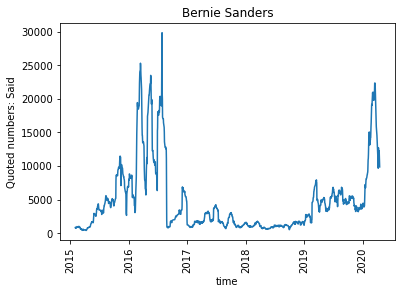

In [13]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Quoted numbers: Said')
plt.title('Bernie Sanders')

**1.3** We compute the total number of quotations until their election. The election dataset only contains the year of election. However, since the U.S. Senate elections always take place in the first week of November, we just compute the total number of quotations until November.1st of the election year.

In [14]:
# Add the election day corresponding to each candidate speaker
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes['election_day'] = candidate_quotes['speaker'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes['election_day'] = pd.to_datetime(candidate_quotes['election_day'])

In [15]:
# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

In [16]:
# We group the number of quotations by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

Pearson coefficient: 0.6112235983030401, p value: 3.506776291721692e-26


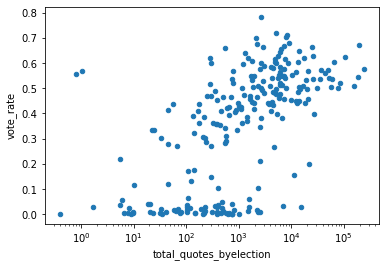

In [17]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is a positive correlation between quotations and vote_rate with p value < 0.05. The more a candidate was quoted before the election, the higher the voting rate he or she got.

**1.4** We can also apply the analysis on quotations that mention senates.

In [18]:
# Load the stored quotations mention senate candidates since 2015 (by year)
senate_quote_20_mention = pd.read_json('SenateData/quotes-2020-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_19_mention = pd.read_json('SenateData/quotes-2019-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_18_mention = pd.read_json('SenateData/quotes-2018-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_17_mention = pd.read_json('SenateData/quotes-2017-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_16_mention = pd.read_json('SenateData/quotes-2016-senates-mention.json.bz2', lines=True, compression='bz2')
senate_quote_15_mention = pd.read_json('SenateData/quotes-2015-senates-mention.json.bz2', lines=True, compression='bz2')

In [19]:
# Concatenate data across all years and display the format of quotation data
annual_frames_mention = [senate_quote_15_mention, senate_quote_16_mention, senate_quote_17_mention, senate_quote_18_mention, senate_quote_19_mention, senate_quote_20_mention]
candidate_quotes_mention = pd.concat(annual_frames_mention)
candidate_quotes_mention.sample(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains
14121,2018-08-07-002318,A vote for Jon Tester is a vote for [ Sen. ] C...,President Trump,[Q22686],2018-08-07 19:02:21,1,"[[President Trump, 0.6264], [None, 0.3736]]",[http://thehill.com/homenews/campaign/400764-m...,E,Charles E. Schumer,[com]
10528,2016-05-19-104159,"the numbers are very positive for Clinton, [ b...",Dianne Feinstein,[Q230733],2016-05-19 07:50:00,3,"[[Dianne Feinstein, 0.9362], [None, 0.0366], [...",[http://news.smh.com.au/world/us-election/us-e...,E,Bernie Sanders,"[com.au, com.au, com.au]"
11432,2018-08-11-034593,Rand Paul just gave one of the most important ...,None,[],2018-08-11 16:00:12,1,"[[None, 0.6389], [Rand Paul, 0.3382], [Vladimi...",[https://www.washingtonexaminer.com/opinion/ra...,E,Rand Paul,[com]
7605,2017-07-25-030592,Gore is the most polarising figure in climate ...,None,[],2017-07-25 08:25:27,1,"[[None, 0.8475], [Al Gore, 0.1525]]",[https://www.carbonbrief.org/daily-brief/uk-mo...,E,Jim Inhofe,[org]


In [20]:
# format the date
candidate_quotes_mention['date_only'] = candidate_quotes_mention['date'].dt.date
# change the name to upper format
candidate_quotes_mention['mention'] = candidate_quotes_mention['mention'].str.upper()

# Normalize the quotes
candidate_quotes_mention['normalize_factor'] = candidate_quotes_mention['date'].map(lambda x: 1/quote_num[str(x)[:7]]*1e6)
candidate_quotes_mention['normalize_quotes'] = candidate_quotes_mention['numOccurrences']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes
12754,2016-04-21-147151,With Bernie Sanders close to being mathematica...,None,[],2016-04-21 14:00:00,1,"[[None, 0.7556], [Hillary Clinton, 0.1957], [E...",[http://host.madison.com/ct/news/local/roundup...,E,ELIZABETH A. WARREN,[com],2016-04-21,0.939819,0.939819
10126,2018-09-10-057143,"Kylian Mbappe, Fabinho, Benjamin Mendy, Bernar...",None,[],2018-09-10 09:10:00,1,"[[None, 0.9299], [James Rodriguez, 0.0201], [B...",[https://www.dailystar.co.uk/sport/football/72...,E,BENJAMIN RODRIGUEZ,[co.uk],2018-09-10,0.459009,0.459009
7319,2017-07-10-021906,Former presidential candidate Bernie Sanders w...,Bernie Sanders,[Q359442],2017-07-10 18:00:37,1,"[[Bernie Sanders, 0.6093], [None, 0.3533], [La...",[https://insurancenewsnet.com/oarticle/senate-...,E,BERNIE SANDERS,[com],2017-07-10,0.418827,0.418827
4477,2018-08-24-029774,I really want to see Ted Cruz out of office.,None,[],2018-08-24 08:42:00,2,"[[None, 0.87], [Lupe Valdez, 0.13]]",[https://www.nbcnews.com/news/latino/texas-bet...,E,TED CRUZ,"[com, com]",2018-08-24,0.497688,0.995375
10423,2017-04-25-114738,The president offered this to Senate majority ...,Michael Anton,[Q28732670],2017-04-25 18:36:42,1,"[[Michael Anton, 0.5746], [None, 0.275], [Pres...",[http://feeds.inquisitr.com/~r/google/yDYq/~3/...,E,MITCH MCCONNELL,[com],2017-04-25,0.398950,0.398950


In [21]:
# obtain normalized quotations by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotes'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16    0.601997
                  2015-08-04    0.473512
                  2015-12-11    0.955093
                  2017-02-12    2.080072
                  2017-05-28    0.401338
                                  ...   
WILLIE L. WILSON  2019-03-30    0.503878
                  2019-07-16    0.668486
                  2019-11-04    0.542426
ZAK RINGELSTEIN   2018-06-22    0.482000
                  2018-10-24    0.427106
Name: normalize_quotes, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

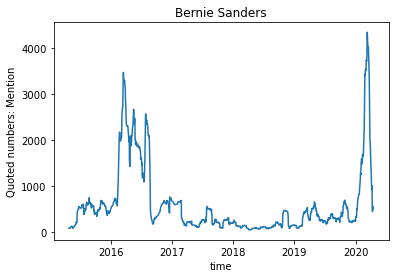

In [22]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

In [23]:
# Add the election day corresponding to each candidate mentioned
candidate_info_byname = candidate_info.set_index(['candidate']) # Allow access info by name as index
candidate_quotes_mention['mention']=candidate_quotes_mention.mention.map(lambda x:x.upper())
candidate_quotes_mention['election_day'] = candidate_quotes_mention['mention'].map(candidate_info_byname['year']).astype(str)+ '-11-01'
candidate_quotes_mention['election_day'] = pd.to_datetime(candidate_quotes_mention['election_day'])
candidate_quotes_mention.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day
0,2015-05-17-016225,I really like Bernie Sanders and his policies ...,None,[],2015-05-17 07:09:22,1,"[[None, 0.81], [Bernie Sanders, 0.19]]",[http://dailykos.com/story/2015/05/15/1384917/...,E,BERNIE SANDERS,[com],2015-05-17,0.880164,0.880164,2018-11-01
1,2015-08-25-018582,Elizabeth Warren does have a thumb on the puls...,Bakari Sellers,[Q4849014],2015-08-25 10:02:35,4,"[[Bakari Sellers, 0.8813], [None, 0.1075], [El...",[http://www.kspr.com/news/politics/does-elizab...,E,ELIZABETH A. WARREN,"[com, com, com, com]",2015-08-25,0.473512,1.894046,2018-11-01
2,2015-03-11-040221,I'll invoke the marital privilege on some of i...,Mike Coffman,[Q547218],2015-03-11 17:09:31,1,"[[Mike Coffman, 0.4786], [None, 0.3104], [Tom ...",[http://www.huffingtonpost.com/jason-salzman/r...,E,CORY GARDNER,[com],2015-03-11,0.535357,0.535357,2020-11-01
3,2015-09-24-081451,Richard Burr truly is North Carolina's `Invisi...,None,[],2015-09-24 02:04:45,1,"[[None, 0.7571], [Richard Burr, 0.182], [Paul ...",[http://www.wcti12.com/news/Ross-leaves-job-po...,E,RICHARD BURR,[com],2015-09-24,0.447555,0.447555,2016-11-01


Pearson coefficient: 0.5320764453359699, p value: 1.1343252830666171e-22


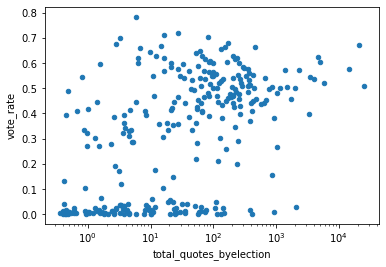

In [24]:
from scipy.stats import pearsonr

# Add election result (i.e. vote rate) for each candidate speaker
candidate_info_byname['vote_rate'] = candidate_info_byname['candidatevotes']/candidate_info_byname['totalvotes']

# We group the number of normalized quotations before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotes'].sum())
tot_quotes_byelection.rename(columns = {'normalize_quotes': 'total_quotes_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_quotes_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_quotes_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

**Observation**: Based on the plot above, we can see that there is also a positive correlation between number of mentioned quotations and vote_rate with p value < 0.05.

## 2. Weigh the quotations by readership
We are aware of the different reading statistics of different media. We try to weigh the quotations by the readership of the source media.

**2.1** First, we sample 50k quotes and look at the source media of those quotations. This would give us a feel of how much media is covered by QuoteBank and which media appear most often. To balance the data said by candidates and the data mentioning candidates, we sample the 50k quotes according to the ratio of total data in 'candidate_quotes' and 'candidate_quotes_mention'

In [25]:
# sample 50k quotes and see where quotes are published
candidate_quotes_mention.reset_index(inplace=True) # Reset index of mention dataset
sample_n = 50000
said_n = len(candidate_quotes.index) # total number of quotes said by candidates
mention_n = len(candidate_quotes_mention.index) # total number of quotes mentioning candidates
mention_sample_n = int(sample_n * mention_n/(mention_n + said_n))
said_sample_n = sample_n - mention_sample_n
print('we sample {} quotes said by candidates and {} quotes mentioning candidates'.format(said_sample_n, mention_sample_n))

we sample 46123 quotes said by candidates and 3877 quotes mentioning candidates


In [26]:
# We extract the domains from two data set based on the ratio computed above
total_domains = []
said_sample = candidate_quotes.sample(said_sample_n) # sample from quotes said by candidates
# We extract web domains from the url
for i in said_sample.index:
    urls = said_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

mention_sample = candidate_quotes.sample(mention_sample_n) # sample from quotes said by candidates
# We use the same pipeline to extract domain
for i in mention_sample.index:
    urls = mention_sample.at[i,'urls']
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        total_domains.append(get_tld(url, as_object=True).domain)

We use the code below to find top 30 frequently appearing media in the sample. (Note: the last several media may be different from sample to sample, but overall they do not affect the result!)

In [27]:
# Count the frequency of media occurences in quotation dataset
from collections import Counter
domain_count = Counter(total_domains).most_common()
print("----top 30 news agency/publisher:\n ", domain_count[0:30])
print('----number of news agency covered:', len(domain_count))


----top 30 news agency/publisher:
  [('krmg', 5670), ('msn', 3356), ('news965', 3127), ('wokv', 2908), ('businessinsider', 2609), ('yahoo', 2556), ('breitbart', 2532), ('thehill', 2333), ('washingtonexaminer', 2234), ('washingtontimes', 2192), ('cnn', 2025), ('cbsnews', 1941), ('einnews', 1843), ('newsmax', 1818), ('foxnews', 1686), ('nytimes', 1556), ('washingtonpost', 1333), ('nbcnews', 1285), ('sfgate', 1214), ('huffingtonpost', 1174), ('wsbradio', 1167), ('kdhnews', 1084), ('news12', 1079), ('ksl', 1018), ('startribune', 992), ('abc-7', 926), ('lmtonline', 920), ('politico', 889), ('seattletimes', 883), ('newsweek', 872)]
----number of news agency covered: 4753


Among 50k samples, there are over 4000 different website domains, indicating a sufficiently wide coverage of media. So the quotations can be an indicator of public exposure. Besides, we observe an exponential decrease of counts in the database.

Text(0.5, 0, 'occurences in sampled quote data')

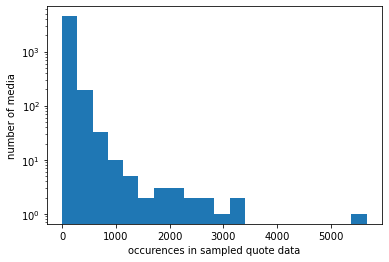

In [28]:
# Plot the histogram characterizing the frequency of each media appearing
_, y_counts = zip(*domain_count)
plt.hist(y_counts, bins=20)
plt.yscale('log')
plt.ylabel('number of media')
plt.xlabel('occurences in sampled quote data')

**Do Not Re run the cell below! In case sample changes**

10 randomly selected news agency/publisher except the top 30:

  ['bakersfield','wtkr', 'go', 'navytimes', 'advertiser-tribune', 'circleofblue', 'nbcphiladelphia', 'malaymail', 'illawarramercury', 'hawaiinewsnow']
  
The code to get the 10 random media is shown below, we comment it out because each time it selects 10 different media, which may confuse the viewer of this notebook.

In [29]:
%%script echo skipping
#media_ind = np.random.randint(31, len(domain_count), size=10)
#print("10 randomly selected news agency/publisher except the top 30:\n ", [domain_count[i] for i in media_ind])

Couldn't find program: 'echo'


The distribution is heavy-tailed, with only a few big media like CNN and Fox News occurring frequently. Most media occurs no more than 1.5% among all quotations. So, we think it is sufficient to just weigh the quotations extracted from those frequently occurring media. Moreover, it is very difficult to automatically find media's reading statistics (or other indicators of popularity) just based on the url major domain name. We could not think of a way to do so. Neither could we find an open dataset helping us. Therefore, we decide to manually look up the readership of those top 30 new agencies. For the rest media, we will sample 10 media from them and manually look up the reading statistics. We will take the average readership of those 10 media to represent the readership of the rest media. This will take up some time, so we plan to finish those manual work in the following weeks (see proposed timeline). As a result, we do not include any exposure level (quotation weighted by media readership) in Milestone 2. Instead, we just use the number of quotations (assuming all media offer the same public exposure).

**2.2** We manually search the total website visits of top 30 news agencies of the 10 randomly selected agencies among the rest. We could not find the data of some websites, so we use the median of others to fill it.

In [27]:
weight_file = 'SenateData/WebsiteVisit.csv'
weight_df = pd.read_csv(weight_file)
# Fill the NaN value by median (which avoid effect from outliers)
weight_df.loc[:, ['total_view_in_US']] = weight_df[['total_view_in_US']].fillna(weight_df[['total_view_in_US']].median())
weight_df.head(5) # demonstrate the format website view data for weight


,webdomain,agency,total_view_in_US,audience,source
0,KRMG,KRMG,0.11,0.033,https://webrate.org/site/krmg.com/
1,news965,WBDO,21.68,NaN,default
2,wokv,WOKV,0.09,0.046,https://webrate.org/site/wokv.com/
3,msn,MSN,323.98,194.400,default
4,breitbart,Breitbart,42.19,40.730,default


In [28]:
# Get the views for the 10 randomly selected agencies
random_file = 'SenateData/RandomVisit.csv'
random_df = pd.read_csv(random_file)
# We take the median of total_US_view of the 10 agencies, as view for other agencies
random_view = random_df['total_view_in_US'].median()
print('The median value of total views of the 10 agencies is {}'.format(random_view))

The median value of total views of the 10 agencies is 0.675


Then, we add those weights to the 'candidate_quotes' and 'candidate_quotes_mention'

In [29]:
# assign weights to quotes said by candidates
weight_dict = dict(zip(weight_df['webdomain'], weight_df['total_view_in_US']))
n_hit = 0
for i in candidate_quotes.index:
    urls = candidate_quotes.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes.at[i,'views'] = weight_ 
print('For quotes said by candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes said by candidates, we found 1044245 numbers of quotation occurrences from top 30


In [30]:
# Multiply views by normalization factors
candidate_quotes['normalize_views'] = candidate_quotes['views']*candidate_quotes['normalize_factor']
candidate_quotes.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views
729713,174771,2018-02-12-120249,treat the most-at-risk parts of the national f...,MARIA CANTWELL,[Q22250],2018-02-12 22:36:00,3,"[[Maria Cantwell, 0.9128], [None, 0.0738], [Ro...",[https://www.opb.org/news/article/wildires-con...,E,"[org, org, org]",0.401482,1.204445,2018-02-12,2018-11-01,2.025,0.813001
131036,131036,2015-05-08-028607,I think we need to resolve it.,RICHARD C. SHELBY,[Q472254],2015-05-08 18:26:07,18,"[[Richard Shelby, 0.7605], [None, 0.2294], [Pr...",[http://www.washingtontimes.com/news/2015/may/...,E,"[com, com, com, com, com, com, com, com, com, ...",0.880164,15.842951,2015-05-08,2016-11-01,57.110,50.266162
491788,177390,2017-12-19-010596,Because it will be tit-for-tat from here on out.,JAMES LANKFORD,[Q45940],2017-12-19 22:39:33,1,"[[James Lankford, 0.6205], [None, 0.3795]]",[http://www.rollcall.com/news/policy/lankford-...,E,[com],0.440932,0.440932,2017-12-19,2016-11-01,0.940,0.414476
17634,17634,2015-11-29-008225,because he's ineligible.,TED CRUZ,[Q2036942],2015-11-29 03:08:30,2,"[[Ted Cruz, 0.4337], [Alan Grayson, 0.3699], [...",[http://forums.sherdog.com/forums/f54/rep-gray...,E,"[com, com]",0.559562,1.119124,2015-11-29,2018-11-01,324.655,181.664607
63127,63127,2015-10-01-046578,I would have liked to see the dials turned mor...,CORY BOOKER,[Q1135767],2015-10-01 12:36:00,2,"[[Cory Booker, 0.5617], [None, 0.416], [Chuck ...",[http://feeds.washingtonpost.com/c/34656/f/636...,E,"[com, net]",0.416694,0.833389,2015-10-01,2020-11-01,120.735,50.309583


In [31]:
# assign weights to quotes mentioning candidates
n_hit = 0
for i in candidate_quotes_mention.index:
    urls = candidate_quotes_mention.at[i,'urls']
    weight_ = 0
    for url in urls: # Some URL here is actually a list (there are lists in list), not sure why it happens
        webdomain = get_tld(url, as_object=True).domain # when it is a list, the multiply urls point to the same website
        if webdomain in weight_dict.keys():
            weight_ = weight_ + weight_dict[webdomain]
            n_hit = n_hit + 1
        else:
            weight_ = weight_ + random_view
    candidate_quotes_mention.at[i,'views'] = weight_ 
print('For quotes mentioning candidates, we found {} numbers of quotation occurrences from top 30'.format(n_hit))

For quotes mentioning candidates, we found 64689 numbers of quotation occurrences from top 30


In [32]:
# Multiply views by normalization factors
candidate_quotes_mention['normalize_views'] = candidate_quotes_mention['views']*candidate_quotes_mention['normalize_factor']
candidate_quotes_mention.sample(5)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,mention,domains,date_only,normalize_factor,normalize_quotes,election_day,views,normalize_views
78037,8596,2019-02-01-097523,The vast majority of Senate Republicans backed...,None,[],2019-02-01 01:30:11,1,"[[None, 0.8876], [Mitch McConnell, 0.0775], [P...",[http://nationaljournal.com/s/676343],E,MITCH MCCONNELL,[com],2019-02-01,0.541812,0.541812,2020-11-01,0.675,0.365723
45188,12878,2017-09-08-090164,"Republican candidate, whether it's Josh Hawley...",James Harris,"[Q15078247, Q20202184, Q23655847, Q56378354, Q...",2017-09-08 12:00:00,1,"[[James Harris, 0.6159], [None, 0.3326], [Pres...",[http://www.kansascity.com/news/politics-gover...,E,JOSH HAWLEY,[com],2017-09-08,0.370432,0.370432,2018-11-01,0.675,0.250042
91255,5270,2020-01-09-011025,But at the end of the day just like we control...,None,[],2020-01-09 14:38:57,1,"[[None, 0.4615], [Adam Smith, 0.3633], [Trent ...",[http://breitbart.com/politics/2020/01/09/dem-...,E,MITCH MCCONNELL,[com],2020-01-09,0.577288,0.577288,2020-11-01,42.190,24.355776
35340,3030,2017-06-29-024034,"FILE - In this Jan. 28, 2017, file photo, prot...",None,[],2017-06-29 03:47:38,2,"[[None, 0.7597], [John F. Kennedy, 0.2403]]",[http://newsok.com/qa-border-officers-take-key...,E,JOHN KENNEDY,"[com, com]",2017-06-29,0.411438,0.822875,2016-11-01,1.350,0.555441
20489,4192,2016-05-10-119047,There's still some hard feelings and this isn'...,Mike Rounds,[Q722503],2016-05-10 04:37:50,14,"[[Mike Rounds, 0.775], [None, 0.1756], [John M...",[http://ksbw.com/politics/mcconnell-shows-conf...,E,JOHN MCCAIN,"[com, com, com, com, com, com, com, com, com, ...",2016-05-10,0.438534,6.139478,2016-11-01,401.375,176.016654


**2.3** We repeat the protocol in section **1.2-1.3** to examine the effect of weighted quotations by candidates on their election results 

In [33]:
# Clean the names by taking only upper case
# Group the candidate total number of quotes by day
candidate_quotes['speaker'] = candidate_quotes['speaker'].str.upper()
candidate_quotes['date_only'] = candidate_quotes['date'].dt.date
candidate_views_byday = candidate_quotes.groupby(['speaker', 'date_only'])['normalize_views'].sum()
candidate_views_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.406348
                  2015-02-09    0.406745
                  2015-02-11    0.813489
                  2015-02-20    0.406745
                  2015-03-01    0.361366
                                  ...   
ZAK RINGELSTEIN   2018-10-30    3.459560
                  2018-11-01    1.607768
                  2018-11-05    0.321554
                  2018-11-07    0.321554
                  2019-03-21    0.340118
Name: normalize_views, Length: 136070, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

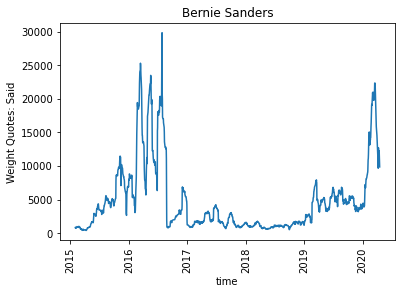

In [34]:
# For example, we can visualize the quotation changes of Bernie Sanders
candidate_quotes_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.xticks(rotation=90)
plt.ylabel('Weight Quotes: Said')
plt.title('Bernie Sanders')

In [35]:
# We group weighted quotations (audience views) by election day
quotes_byelection = candidate_quotes[candidate_quotes['date_only'] < candidate_quotes['election_day']]
views_byelection = pd.DataFrame(quotes_byelection.groupby(['speaker'])['normalize_views'].sum())
views_byelection.rename(columns = {'normalize_views': 'views_byelection'}, inplace=True)

Pearson coefficient: 0.6230464918664673, p value: 2.0338894729023706e-27


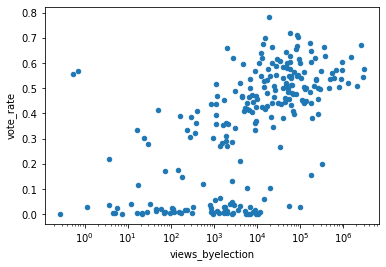

In [36]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
from scipy.stats import pearsonr
views_byelection['vote_rate'] = views_byelection.index.map(candidate_info_byname['vote_rate'])
views_vote = views_byelection.plot.scatter(x = 'views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(views_byelection['views_byelection']), views_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')


We notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.3** (where we did not weigh the quotes by website views). 

**2.4** We repeat the protocol in section **1.4** to examine the effect of weighted quotations mentioning candidates on their election results

In [37]:
# obtain normalized views by day
candidate_quotes_mention_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_views'].sum()
candidate_quotes_mention_byday

mention           date_only 
A. WAYNE JOHNSON  2015-01-16      0.406348
                  2015-08-04    153.408265
                  2015-12-11      0.644688
                  2017-02-12      1.404049
                  2017-05-28      0.270903
                                   ...    
WILLIE L. WILSON  2019-03-30      0.340118
                  2019-07-16     28.203418
                  2019-11-04     11.759805
ZAK RINGELSTEIN   2018-06-22      0.325350
                  2018-10-24      0.288297
Name: normalize_views, Length: 34904, dtype: float64

Text(0.5, 1.0, 'Bernie Sanders')

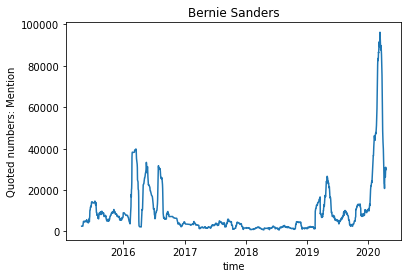

In [38]:
# For example, we can visualize the normalized view changes of Bernie Sanders
candidate_quotes_mention_byday['BERNIE SANDERS'].rolling(window=30).sum().plot() # one months average
plt.xlabel('time')
plt.ylabel('Quoted numbers: Mention')
plt.title('Bernie Sanders')

Pearson coefficient: 0.5930863043667436, p value: 4.9198504923098316e-29


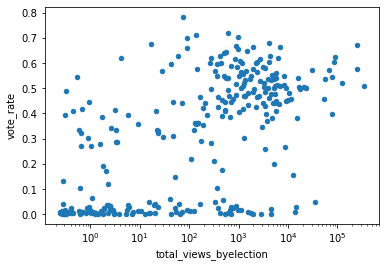

In [39]:
from scipy.stats import pearsonr

# We group the number of normalized views before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
tot_quotes_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_views'].sum())
tot_quotes_byelection.rename(columns = {'normalize_views': 'total_views_byelection'}, inplace=True)

# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
tot_quotes_byelection['vote_rate'] = tot_quotes_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
quotes_vote = tot_quotes_byelection.plot.scatter(x = 'total_views_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(np.log(tot_quotes_byelection['total_views_byelection']), tot_quotes_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

Again, we notice very little change in the Pearson coefficient and p-value when comparing the result to section **1.4** (where we did not weigh the quotes by website views). 

# 3. Clustering the quotation data
To answer our proposed question 3, we clustered the quotation data to find different exposure-gaining process.

We will extract feature for each senate candidate.

In [40]:
candidate_quotes['days_before_election'] = pd.to_datetime(candidate_quotes['election_day'])- pd.to_datetime(candidate_quotes['date_only'])
candidate_quotes['days_before_election'] = candidate_quotes['days_before_election'].map(lambda x:x.days)
candidate_quotes.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
868092,59639,2019-05-23-090228,That's not going to be a permanent decision by...,SUSAN MARGARET COLLINS,"[Q22279, Q7647692]",2019-05-23 11:55:00,2,"[[Susan Collins, 0.914], [None, 0.0664], [Pres...",[https://www.ajot.com/news/trump-sacrifices-ag...,E,"[com, com]",0.488273,0.976546,2019-05-23,2020-11-01,1.350,0.659169,528
523242,208844,2017-05-31-070918,"It's going to be a tough political process,",RON JOHNSON,"[Q1741083, Q19879325, Q20639273, Q21229090, Q2...",2017-05-31 16:03:51,2,"[[Ron Johnson, 0.6467], [None, 0.3451], [Presi...",[https://insurancenewsnet.com/oarticle/ron-joh...,E,"[com, com]",0.401338,0.802676,2017-05-31,2016-11-01,1.350,0.541806,-211
92318,92318,2015-08-14-022606,Having been through plenty of transformations ...,TOM JONES,"[Q16091498, Q16730416, Q180850, Q23303147, Q23...",2015-08-14 16:53:00,81,"[[Tom Jones, 0.7412], [None, 0.1427], [Paloma ...",[http://www.irishmirror.ie/whats-on/film-news/...,E,"[ie, co.uk, co.uk, co.uk, co.uk, ie, com, com,...",0.473512,38.354434,2015-08-14,2016-11-01,223.255,105.713816,445
423339,108941,2017-06-19-105794,This is certainly taking on a proportion of dr...,KAMALA D. HARRIS,[Q10853588],2017-06-19 10:52:07,3,"[[Sen. Kamala Harris, 0.7465], [None, 0.1858],...",[http://www.bradenton.com/news/politics-govern...,E,"[com, com, com]",0.411438,1.234313,2017-06-19,2016-11-01,2.025,0.833161,-230


In [41]:
feature_length = 300  # we use data of 100 days before the election
quotes_timespan = candidate_quotes[candidate_quotes['days_before_election']>=0]
quotes_timespan = quotes_timespan[quotes_timespan['days_before_election']<feature_length]
quotes_timespan.sample(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election
696394,141452,2018-07-16-024323,He is still enjoying his game and his finishin...,GARY E JOHNSON,"[Q16019429, Q16193173, Q17476680, Q21035495, Q...",2018-07-16 12:45:05,2,"[[Gary Johnson, 0.7593], [Mohamed Eisa, 0.1166...",[https://www.coventrytelegraph.net/sport/footb...,E,"[net, net]",0.517383,1.034767,2018-07-16,2018-11-01,1.350,0.698467,108
201821,10237,2016-04-25-022262,"great integrity, honesty and vision",TOM JONES,"[Q16091498, Q16730416, Q180850, Q23303147, Q23...",2016-04-25 00:00:00,1,"[[Tom Jones, 0.5142], [None, 0.4163], [David H...",[http://leaderlive.co.uk:80/news/161297/mourne...,E,[co.uk],0.939819,0.939819,2016-04-25,2016-11-01,0.675,0.634378,190
654363,99421,2018-08-27-015636,corporations should focus only on maximising r...,ELIZABETH A. WARREN,[Q434706],2018-08-27 15:42:59,1,"[[Elizabeth Warren, 0.8857], [None, 0.1143]]",[https://www.fin24.com/Economy/Labour/opinion-...,E,[com],0.497688,0.497688,2018-08-27,2018-11-01,0.675,0.335939,66
771478,216536,2018-04-21-023354,I felt quite prepared to take the task on. Her...,TINA SMITH,"[Q18631509, Q22670437]",2018-04-21 21:16:54,1,"[[Tina Smith, 0.8973], [None, 0.1027]]",[http://www.startribune.com/tina-smith-settles...,E,[com],0.386958,0.386958,2018-04-21,2018-11-01,9.810,3.796053,194


In [42]:
# group the quotations by speaker
quotes_timespan_byday = quotes_timespan.groupby(['speaker', 'days_before_election'])['normalize_views'].sum()
quotes_timespan_byday

speaker           days_before_election
A. WAYNE JOHNSON  225                      0.510070
                  234                      2.040281
                  241                     11.395348
                  251                     99.717389
                  261                      2.532803
                                            ...    
ZAK RINGELSTEIN   141                      1.626749
                  147                      0.650700
                  160                      0.815621
                  227                      1.933979
                  235                      0.241747
Name: normalize_views, Length: 19165, dtype: float64

In [43]:
# build the feature vectors

candidate_name = quotes_timespan_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_cluster_feature = pd.DataFrame(np.zeros([feature_length,len(candidate_name)]), columns=candidate_name)

for candidate in candidate_name:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature

,A. WAYNE JOHNSON,AARON JAMES,ABHAY PATEL,AL GROSS,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,AMY MCGRATH,ANN KIRKPATRICK,ARN MENCONI,...,TOM COTTON,TOM JONES,TOMMY TUBERVILLE,TONY CAMPBELL,TROY HEBERT,VALENCIA STOVALL,WENDY LONG,"WILLIAM ROBERT LANG, JR.",WILLIE L. WILSON,ZAK RINGELSTEIN
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.643107,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.607768
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.864890,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.0,41.414354,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.459560
3,0.0,0.000000,0.0,0.0,0.0,0.0,4.324450,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,2.306374,0.0,0.0,0.0,0.0,0.0,0.576593
4,0.0,0.000000,0.0,0.0,0.0,0.0,4.901044,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,2.882967,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.000000,0.0,0.0,0.0,0.0,69.388074,0.000000,0.0,0.0,...,552.756030,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
296,0.0,1.169008,0.0,0.0,0.0,0.0,8.435176,0.000000,0.0,0.0,...,3.896693,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
297,0.0,0.779339,0.0,0.0,0.0,0.0,1.357593,1.169008,0.0,0.0,...,239.637971,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
298,0.0,0.779339,0.0,0.0,0.0,0.0,0.814556,0.000000,0.0,0.0,...,756.541538,0.0,191.316089,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


Since the feature vector is 300-dimension, we will use PCA to reduce the dimension and visualize the data.

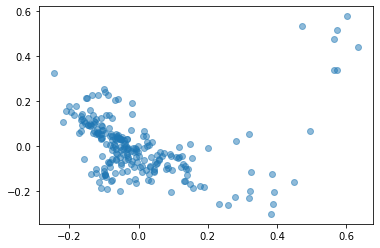

In [44]:
# Use PCA to visualize the feature vectors
from sklearn.decomposition import PCA

candidate_feature_vectors = candidate_quotes_cluster_feature.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

In the reduced space, we applied KMeans for clustering.

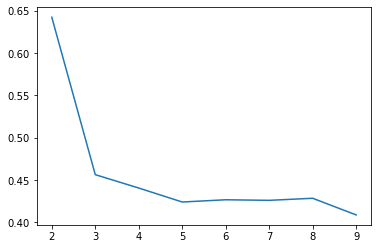

In [45]:
# find the cluster number to use

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

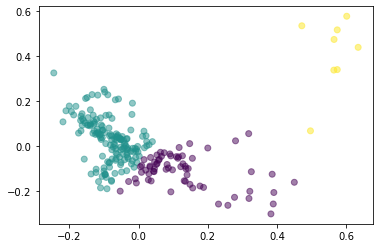

In [46]:
# based on previous result, we use 3 clusters.
n_clusters = 3
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [47]:
# show candidates of each cluster

for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

67 candidates in type 0: Index(['AARON JAMES', 'AL GROSS', 'BARBARA BOLLIER', 'BEN CARDIN', 'BEN SASSE',
       'BERNIE SANDERS', 'BILL HAGERTY', 'BOB WALSH', 'CINDY HYDE-SMITH',
       'CORY BOOKER', 'CORY GARDNER', 'DAN SULLIVAN', 'DANIEL BURKE',
       'DANIEL M. GADE', 'DAVID BARIA', 'DAVID F. BLACK', 'DAVID MORAN',
       'DOUG COLLINS', 'DOUG JONES', 'ED TARVER', 'EDWARD J. MARKEY',
       'GARY TRAUNER', 'JAIME HARRISON', 'JEFF RUSSELL', 'JERRY TROOIEN',
       'JIM RENACCI', 'JIM RISCH', 'JIM SCHULTZ', 'JOE MANCHIN',
       'JOHN BARRASSO', 'JOHN CORNYN', 'JOHN F. REED', 'JOHN W. HICKENLOOPER',
       'JOHN WAYNE HOWE', 'JONI ERNST', 'KEVIN E. HAYES', 'KEVIN O'CONNOR',
       'LINDSEY GRAHAM', 'MARK R. WARNER', 'MARTHA MCSALLY',
       'MARTIN T HEINRICH', 'MARY "MJ" HEGAR', 'MATT LIEBERMAN',
       'MICHAEL SANCHEZ', 'MICHAEL TODD GREENE', 'MIKE ESPY', 'MIKE ROUNDS',
       'MITCH MCCONNELL', 'MOHAMMAD "MIKE OBAMA" ARIF', 'NEAL SIMON',
       'PATRICK "PAT" THOMAS', 'PAULA JEA

After clustering, we'd like to know how each cluster looks like. Firstly we just average the feature from each cluster and visualize them.

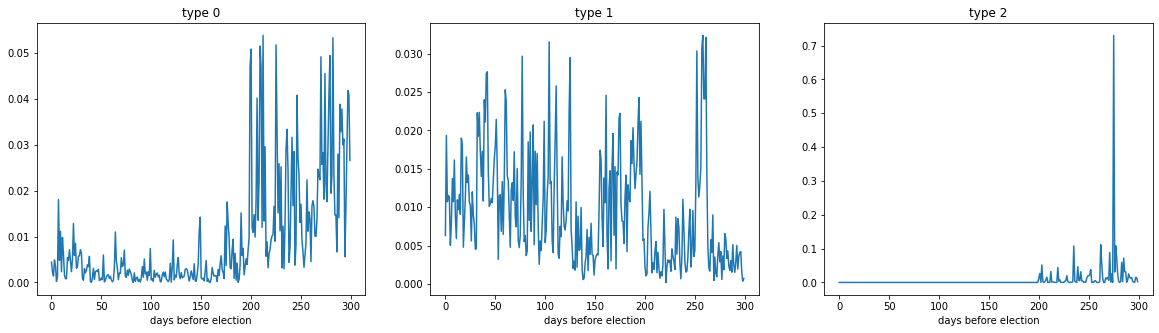

In [48]:
fig, axs = plt.subplots(1,n_clusters, figsize=(20,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('days before election')

We try to remove candidate of 2020 because the lack of data after April. This is shown in type 0, where we get almost no citation from roughly 200 days before election. This is mainly caused by lacking quotation data after April 2020 in the QuoteBank.

In [49]:
# find each candidates' election year.

election_year = candidate_info_byname.loc[candidate_name]['year']
election_year

A. WAYNE JOHNSON            2020
AARON JAMES                 2020
ABHAY PATEL                 2016
AL GROSS                    2020
ALEX MERCED                 2016
                            ... 
VALENCIA STOVALL            2020
WENDY LONG                  2016
WILLIAM ROBERT LANG, JR.    2016
WILLIE L. WILSON            2020
ZAK RINGELSTEIN             2018
Name: year, Length: 234, dtype: int64

In [50]:
# filt out 2020 election

candidate_name_filted = candidate_name[election_year!=2020]
candidate_name_filted

Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'AMY KLOBUCHAR',
       'ANN KIRKPATRICK', 'ARN MENCONI', 'ARVIN VOHRA', 'BARRY MICHAELS',
       'BEN CARDIN', 'BERNIE SANDERS',
       ...
       'TIMOTHY M. KAINE', 'TINA SMITH', 'TODD C. YOUNG', 'TOM CONNORS',
       'TOM JONES', 'TONY CAMPBELL', 'TROY HEBERT', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'ZAK RINGELSTEIN'],
      dtype='object', length=171)

In [51]:
# rebuild our feature vectors

candidate_quotes_cluster_feature_filted = pd.DataFrame(np.zeros([feature_length,len(candidate_name_filted)]), columns=candidate_name_filted)

for candidate in candidate_name_filted:
    candidate_quotes_timespan = quotes_timespan_byday[candidate]
    for days in candidate_quotes_timespan.index:
        candidate_quotes_cluster_feature_filted[candidate].iloc[days] = candidate_quotes_timespan.loc[days]
        
candidate_quotes_cluster_feature_filted

,ABHAY PATEL,ALEX MERCED,ALLEN BUCKLEY,AMY KLOBUCHAR,ANN KIRKPATRICK,ARN MENCONI,ARVIN VOHRA,BARRY MICHAELS,BEN CARDIN,BERNIE SANDERS,...,TIMOTHY M. KAINE,TINA SMITH,TODD C. YOUNG,TOM CONNORS,TOM JONES,TONY CAMPBELL,TROY HEBERT,WENDY LONG,"WILLIAM ROBERT LANG, JR.",ZAK RINGELSTEIN
0,0.0,0.0,0.0,0.643107,0.0,0.0,0.000000,0.00000,0.964661,60.447298,...,0.0,45.258062,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.607768
1,0.0,0.0,0.0,0.864890,0.0,0.0,0.000000,0.00000,0.864890,1160.084533,...,0.0,0.576593,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,41.414354,0.0,0.0,0.000000,0.00000,3.171264,89.959246,...,0.0,45.040485,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.459560
3,0.0,0.0,0.0,4.324450,0.0,0.0,1.153187,0.00000,3.171264,407.068522,...,0.0,0.000000,0.0,0.0,0.0,2.306374,0.0,0.0,0.0,0.576593
4,0.0,0.0,0.0,4.901044,0.0,0.0,0.000000,0.86489,3.747857,2512.988300,...,0.0,1.441483,0.0,0.0,0.0,2.882967,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,69.388074,0.0,0.0,0.000000,0.00000,3464.657134,0.814556,...,0.0,1.900630,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
296,0.0,0.0,0.0,8.435176,0.0,0.0,0.000000,0.00000,1134.143035,199.262435,...,0.0,0.814556,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
297,0.0,0.0,0.0,1.357593,0.0,0.0,0.000000,0.00000,0.271519,51.317006,...,0.0,47.781231,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
298,0.0,0.0,0.0,0.814556,0.0,0.0,0.000000,0.00000,0.814556,935.498054,...,0.0,11.150362,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


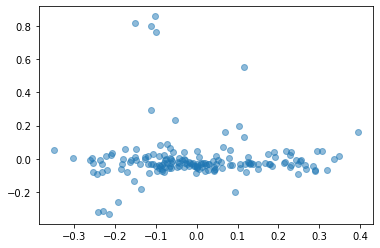

In [52]:
# PCA visualization
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors).transform(candidate_feature_vectors)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

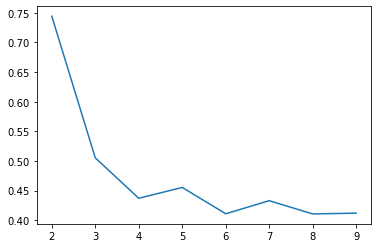

In [53]:
# find cluster number
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)

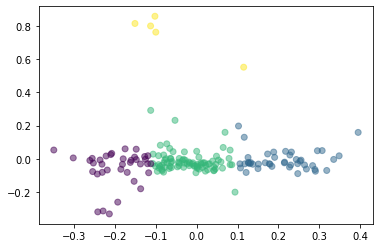

In [54]:
n_clusters = 4
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

In [55]:
# again we show the candidates of each cluster
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name[np.where(labels==candidate_type)]))

37 candidates in type 0: Index(['A. WAYNE JOHNSON', 'ABHAY PATEL', 'ALEX MERCED', 'BEN SASSE',
       'BILL HAGERTY', 'BILL NELSON', 'CAL CUNNINGHAM', 'DARRYL GLENN',
       'DAVID A. PERDUE', 'DEAN HELLER', 'DERRICK EDWARDS', 'DIANNE FEINSTEIN',
       'JASON LEWIS', 'JIM NEWBERGER', 'JIM RENACCI', 'JOE DONNELLY',
       'JOE MANCHIN', 'JOHN BARRASSO', 'JOHN JAMES', 'JOHN R. THUNE',
       'JOHN WAYNE HOWE', 'JOSH HAWLEY', 'KATIE MCGINTY', 'KELLY AYOTTE',
       'KEVIN O'CONNOR', 'LILY TANG WILLIAMS', 'LORETTA SANCHEZ',
       'MARIA CANTWELL', 'MARK R. WARNER', 'MARK T. BEARD', 'MARSHA BLACKBURN',
       'MICHAEL TODD GREENE', 'MIKE BRAUN', 'MIKE ESPY', 'MISTY K. SNOW',
       'PATRICK J. LEAHY', 'PATRICK MURPHY'],
      dtype='object')
44 candidates in type 1: Index(['AL GROSS', 'ANN KIRKPATRICK', 'ARN MENCONI', 'ARVIN VOHRA',
       'BARBARA BOLLIER', 'BOB HUGIN', 'CATHERINE CORTEZ MASTO',
       'CONNER ELDRIDGE', 'DALE R KERNS JR', 'DANIEL BURKE', 'DANIEL M. GADE',
       'DAVID 

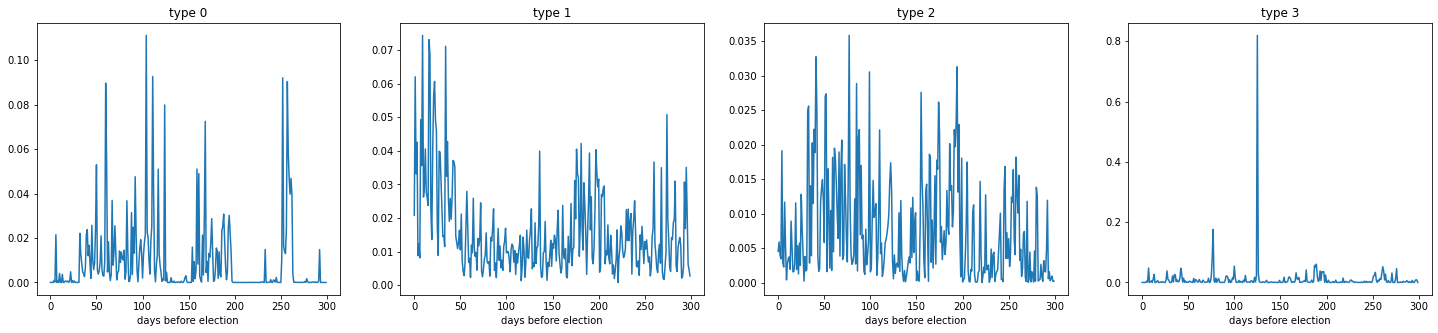

In [56]:
# use simple average to visualize the pattern of each cluster
fig, axs = plt.subplots(1,n_clusters, figsize=(25,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,feature_length), np.mean(candidate_feature_vectors[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('days before election')

We also noticed that for most candidates, their quotation number of each day is relatively sparse. So it is resonable to use a longer time interval for our feature vectors. Here we sum the quotation number of each 30 days.

In [57]:
# sum for each 30 day
candidate_feature_vectors = candidate_quotes_cluster_feature_filted.to_numpy().T
candidate_feature_vectors/=np.linalg.norm(candidate_feature_vectors,axis=1)[:,np.newaxis]
candidate_feature_vectors_sum = np.array(np.split(candidate_feature_vectors,10, axis=1)).sum(axis=2).T

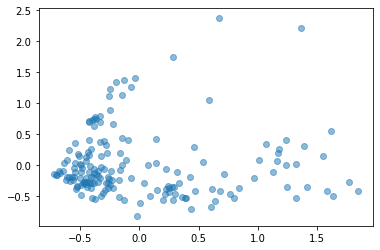

In [58]:
# PCA visualization
reduced_feature_PCA = PCA(n_components=2).fit(candidate_feature_vectors_sum).transform(candidate_feature_vectors_sum)

plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5)

Text(0.5, 0, 'n_clusters')

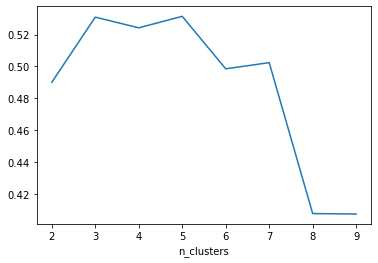

In [59]:
silhouettes=[]
for n_clusters in range(2,10):
    labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
    score = silhouette_score(reduced_feature_PCA,labels)
    silhouettes.append(score)
    
plt.plot(range(2,10),silhouettes)
plt.xlabel('n_clusters')

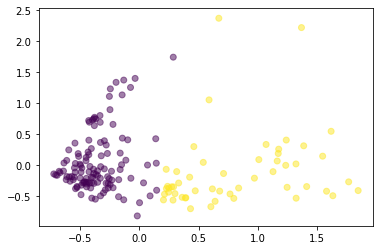

In [60]:
n_clusters = 2
labels = KMeans(n_clusters=n_clusters).fit_predict(reduced_feature_PCA)
plt.scatter(reduced_feature_PCA[:,0],reduced_feature_PCA[:,1], alpha=0.5,c=labels)

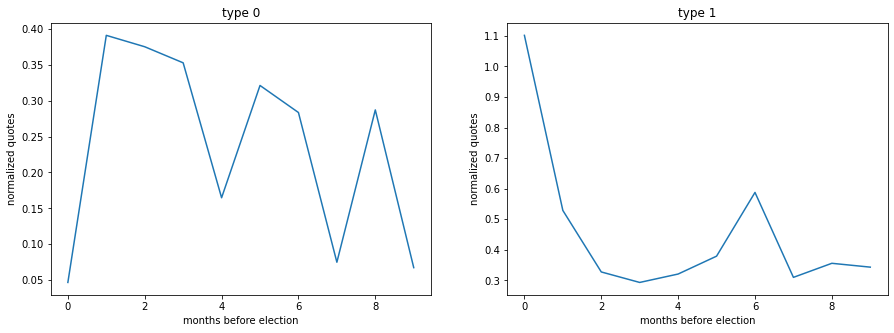

In [61]:
fig, axs = plt.subplots(1,n_clusters, figsize=(15,5))
for candidate_type in range(0,n_clusters):
    axs[candidate_type].plot(range(0,10), np.mean(candidate_feature_vectors_sum[np.where(labels==candidate_type)], axis=0))
    axs[candidate_type].set_title('type {}'.format(candidate_type))
    axs[candidate_type].set_xlabel('months before election')
    axs[candidate_type].set_ylabel('normalized quotes')

In [62]:
for candidate_type in range(0,n_clusters):
    print('{} candidates in type {}: {}'.format(np.where(labels==candidate_type)[0].shape[0],candidate_type,candidate_name_filted[np.where(labels==candidate_type)]))

119 candidates in type 0: Index(['ABHAY PATEL', 'ALEX MERCED', 'ALLEN BUCKLEY', 'ANN KIRKPATRICK',
       'ARVIN VOHRA', 'BARRY MICHAELS', 'BRAD J. PEACOCK', 'BRIAN SCHATZ',
       'CAROLINE FAYARD', 'CATHERINE CORTEZ MASTO',
       ...
       'TIM HAGAN', 'TIM SCOTT', 'TIMOTHY M. KAINE', 'TODD C. YOUNG',
       'TOM CONNORS', 'TOM JONES', 'TROY HEBERT', 'WENDY LONG',
       'WILLIAM ROBERT LANG, JR.', 'ZAK RINGELSTEIN'],
      dtype='object', length=119)
52 candidates in type 1: Index(['AMY KLOBUCHAR', 'ARN MENCONI', 'BEN CARDIN', 'BERNIE SANDERS',
       'BETO O'ROURKE', 'BILL NELSON', 'BOB HUGIN', 'CHELE CHIAVACCI FARLEY',
       'CHUCK GRASSLEY', 'CLAIRE MCCASKILL', 'DEAN HELLER', 'DEB FISCHER',
       'DIANNE FEINSTEIN', 'ELIZABETH A. WARREN', 'ERIC L. BRAKEY',
       'GARY TRAUNER', 'GEOFF DIEHL', 'GEORGE E. HUFFMAN III',
       'HEIDI HEITKAMP', 'JACKY ROSEN', 'JIM NEWBERGER', 'JIM RENACCI',
       'JOE DONNELLY', 'JOE MANCHIN', 'JOHN BARRASSO', 'JOHN JAMES',
       'JOHN MCCAIN

Text(0.5, 1.0, 'JAMES LANKFORD, Type 0 Example')

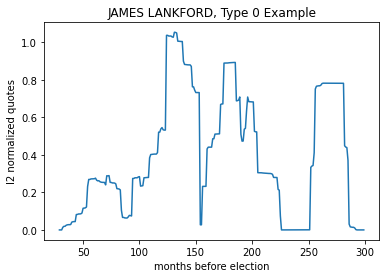

In [63]:
# From type 0
candidate_quotes_cluster_feature_filted['JAMES LANKFORD'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('JAMES LANKFORD, Type 0 Example')

Text(0.5, 1.0, 'Dianne Feinstein, Type 1 Example')

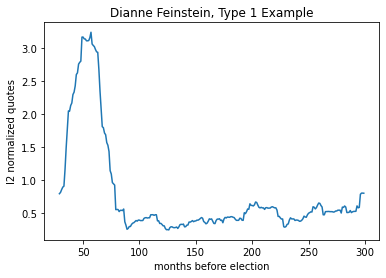

In [64]:
# From type 1
candidate_quotes_cluster_feature_filted['DIANNE FEINSTEIN'].rolling(window=30).sum().plot()
plt.xlabel('months before election')
plt.ylabel('l2 normalized quotes')
plt.title('Dianne Feinstein, Type 1 Example')

In [65]:
voterate_type0 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==0)]]['vote_rate']
voterate_type1 = candidate_info_byname.loc[candidate_name_filted[np.where(labels==1)]]['vote_rate']

([<matplotlib.axis.XTick at 0x7f13987074c0>,
 [Text(1, 0, 'type0'), Text(2, 0, 'type1')])

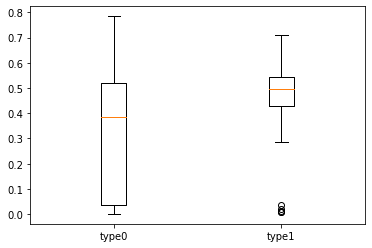

In [66]:
plt.boxplot([voterate_type0.to_numpy(),voterate_type1.to_numpy()])
plt.xticks([1, 2], ['type0', 'type1'])

In [67]:
from scipy.stats import ttest_ind
ttest_ind(voterate_type0.to_numpy(),voterate_type1.to_numpy())

Ttest_indResult(statistic=-3.4705551582259586, pvalue=0.0006592621599715905)

There is significant difference between the voterate of each cluster.

# 4. Prediction Model
In this section, we will try to build the prediction model that uses the senate quotation data to predict election result.

**4.1:** First, we label the data by whether the candidate win the election in a new column 'is_winner'

In [106]:
# Add 'is_winner' feature
candidate_info['is_winner'] = False
candidate_info.loc[candidate_info.groupby(['year', 'state'])['candidatevotes'].idxmax(), 'is_winner'] = True
candidate_info[candidate_info['is_winner'] == True].head(5) # we display 5 winners

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified,is_winner
1,2016,ALABAMA,AL,1,63,41,US SENATE,statewide,gen,False,RICHARD C. SHELBY,REPUBLICAN,False,total,1335104,2087444,False,20210114,REPUBLICAN,True
7,2016,ALASKA,AK,2,94,81,US SENATE,statewide,gen,False,LISA MURKOWSKI,REPUBLICAN,False,total,138149,311441,False,20210114,REPUBLICAN,True
12,2016,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,JOHN MCCAIN,REPUBLICAN,False,total,1359267,2530730,False,20210114,REPUBLICAN,True
14,2016,ARKANSAS,AR,5,71,42,US SENATE,statewide,gen,False,JOHN BOOZMAN,REPUBLICAN,False,total,661984,1107522,False,20210114,REPUBLICAN,True
18,2016,CALIFORNIA,CA,6,93,71,US SENATE,statewide,gen,False,KAMALA D. HARRIS,DEMOCRAT,False,total,7542753,12244170,False,20210114,DEMOCRAT,True


We notice that the dataset also contains situation in which more than one senate are elected in a state in the same year (such situations are officialy called special senate election in the U.S.). To find these special elections, we check whether the sum of candidate votes exceed the total number of votes. 

In [107]:
# Find the special situations
sanity = candidate_info.groupby(['year', 'state'])['candidatevotes'].sum() <= candidate_info.groupby(['year', 'state'])['totalvotes'].mean()
sanity[sanity == False]

year  state      
2018  MINNESOTA      False
      MISSISSIPPI    False
2020  GEORGIA        False
dtype: bool

After manually looking at the dataset, we find two more winners: Tina Smith in 2018 Minnesota election and Cindy Hyde-Smith in 2018 MIssissippi election. The 2020 Georgia election held an additional runoff in 2021, in which Jon Ossof actually won the election. However, since QuoteBank only contains citations before April 2020, the data cannot reflect quotation changes before elections. We have decided not to include elections happening since 2020. So, we just add the two previously overlooked winners.

In [108]:
# Add winners in special elections
candidate_info.loc[candidate_info['candidate'] == 'TINA SMITH','is_winner'] = True
candidate_info.loc[candidate_info['candidate'] == 'CINDY HYDE-SMITH','is_winner'] = True

**4.2:** we now generate features by concatenating the monthly discretized quotation data (defined in clustering section above) and affiliated party information (defined below)

Since affiliated party plays an important role in election, we  include the party affiliation of each candidate. For senate elction in each state, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the senate election from 2016 to 2029, we will use the 2016 presidential election data.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [109]:
# We load 2016 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3631,2016,NEW YORK,NY,36,21,13,US PRESIDENT,NaN,NaN,True,12816,7802084,20210113,NaN,OTHER
3624,2016,NEW YORK,NY,36,21,13,US PRESIDENT,"CLINTON, HILLARY",WORKING FAMILIES,False,140041,7802084,20210113,NaN,OTHER
3703,2016,VERMONT,VT,50,13,6,US PRESIDENT,"LA RIVA, GLORIA ESTELLA",LIBERTY UNION PARTY,False,327,320467,20210113,NaN,OTHER
3456,2016,DELAWARE,DE,10,51,11,US PRESIDENT,"CLINTON, HILLARY",DEMOCRAT,False,235603,441590,20210113,NaN,DEMOCRAT


In [110]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [111]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
party_features = candidate_info_byname[['party_simplified']].copy()
for name in party_features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
        party_features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
    else: 
        party_features.loc[name, 'party_vote_rate'] = 0
        
party_features.sample(5)

,party_simplified,party_vote_rate
candidate,,
MATT J. WATERS,LIBERTARIAN,0.029697
JAY WILLIAMS,DEMOCRAT,0.317374
TIM SCOTT,REPUBLICAN,0.549393
PATTY MURRAY,DEMOCRAT,0.525387
DARRYL GLENN,REPUBLICAN,0.432514


In [112]:
# We get the candidates used for model and extract the vector corresponding to affliated party's performance in last election
candidates_model = candidate_quotes_cluster_feature_filted.T.index
party_vote_model = party_features.loc[candidates_model].party_vote_rate
# We then concatenate this vector to our model
features = np.concatenate((candidate_feature_vectors_sum, party_vote_model.to_numpy()[:, np.newaxis]), axis=1)
print('we have feature vectors from {} candidates, each with dimension {}'.format(features.shape[0], features.shape[1]))

we have feature vectors from 171 candidates, each with dimension 11


In [113]:
# we also obtain the corresponding labels, with 0 meaning lose and 1 meaning win
labels = candidate_info.set_index('candidate').loc[candidates_model].is_winner.astype(int).to_numpy()
print('we have {} winner candidates and {} loser candidate'.format(sum(labels), len(labels) - sum(labels)))


we have 68 winner candidates and 103 loser candidate


In [114]:
# This helps split the data if we want to split train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=123)
print('we have {} training data and {} test data'.format(len(y_train), len(y_test)))

we have 128 training data and 43 test data


**4.3:** We build a Logistic Regression Model to predict the result

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

We use 5-fold cross-validation on the whole dataset, to see how well logistic regression can perform on training set.

In [78]:
logistic = LogisticRegression(solver='lbfgs')
precision = cross_val_score(logistic, X_train, y_train, cv=5, scoring="precision")
recall = cross_val_score(logistic, X_train, y_train, cv=5, scoring="recall")
# Precision: avoid false positives
print("Cross-Validated Training Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Cross-Validated Training Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Cross-Validated Training Precision: 0.72 (+/- 0.22)
Cross-Validated Training Recall: 0.43 (+/- 0.20)


Then, we train the logistic regression on the traing dataset and predict the test dataset

In [79]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train) # train the model
y_preds = logistic.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
print("On the test dataset, we obtain accuracy {} and f1 score {}".format(accuracy, f1))

On the test dataset, we obtain accuracy 0.7441860465116279 and f1 score 0.6666666666666666


We then apply the XGBoost. 

In [128]:
# logistic = LogisticRegression(solver='lbfgs')
clf = xgb.XGBClassifier(
    n_estimators=100,
    reg_lambda=0.5,
    gamma=1,
    max_depth=1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring="precision")
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring="recall")
# Precision: avoid false positives
print("Cross-Validated Training Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Cross-Validated Training Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))

Cross-Validated Training Precision: 0.73 (+/- 0.35)
Cross-Validated Training Recall: 0.69 (+/- 0.23)


In [129]:
import xgboost as xgb
# read in data
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
print("On the test dataset, we obtain accuracy {} and f1 score {}".format(accuracy, f1))

On the test dataset, we obtain accuracy 0.9069767441860465 and f1 score 0.9


# 5. Sentiment Analysis

In [80]:
# Obtain quotation's sentiment toward mentioned candidates
import bz2
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle
analyzer = SentimentIntensityAnalyzer()
from collections import defaultdict


senate_candidates = list(map(lambda x:x.title(), senate_candidates))
senate_candidates_sentiment = defaultdict(list)

#candidate_quotes_mention = pd.read_pickle('SenateData/candidate_quotes_mention.pkl') 
# The above line was used to load previously stored mention data, no need to run it if you have run the above cells
candidate_quotes_mention['quotation_score'] =  candidate_quotes_mention.apply(lambda x: analyzer.polarity_scores(x['quotation'])['compound'], axis=1)
scale = candidate_quotes_mention['normalize_factor'].max() 
# we will divide the above scale factor when normalizing sentiment, to make sure the normalized sentimate still range from -1 to 1
candidate_quotes_mention['normalize_quotation_score'] = candidate_quotes_mention['quotation_score']*(candidate_quotes_mention['normalize_factor']/scale)
for index, instance in candidate_quotes_mention.iterrows():
    senate_candidates_sentiment[instance['mention']].append((instance['date'].date(), instance['quotation_score']))

# The function to extract sentiment of the sentence
def obtain_mean_sentiment(sentiment_list, time_span=None):
    # sentiment_list consists of (date, sentiment), we obtain mean sentiment in each timespan
    # time span (date_lower: str, date upper: str) 
    if time_span is None:
        return sum(map(lambda x: x[1], sentiment_list)) / len(sentiment_list)
    date_start=pd.to_datetime(time_span[0], format='%Y-%m-%d') 
    date_end=pd.to_datetime(time_span[1], format='%Y-%m-%d')
    filtered_sentiment_list = list(filter(lambda x: date_start <= pd.to_datetime(x[0], format='%Y-%m-%d')  < date_end, sentiment_list))
    return sum(map(lambda x: x[1], filtered_sentiment_list)) / max(len(filtered_sentiment_list),1)

We can visualize the sentiment changes toward each candidate over time. We take Bernie Sanders as an example.

Text(0.5, 1.0, 'Bernie Sanders')

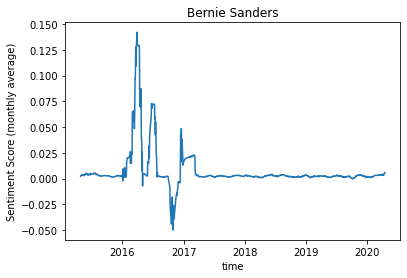

In [81]:
# Group sentiment scores by candidates and dates, average the score in each day
candidate_senti_byday = candidate_quotes_mention.groupby(['mention', 'date_only'])['normalize_quotation_score'].mean()
# Visualize the sentiment change of Bernie Sanders
candidate_senti_byday['BERNIE SANDERS'].rolling(window=30).mean().plot() # we take monthly average for better display
plt.xlabel('time')
plt.ylabel('Sentiment Score (monthly average)')
plt.title('Bernie Sanders')

We then look at the average sentiment toward each candidate within a year before the election. We can compare this to the final vote rate, so that we know whether the sentiment displayed in quotations reflect support rate.

In [82]:
# We group the quotations within 1 year before election day
quotes_byelection = candidate_quotes_mention[candidate_quotes_mention['date_only'] < candidate_quotes_mention['election_day']]
start_date = pd.to_datetime(quotes_byelection ['mention'].map(candidate_info_byname['year'] - 1).astype(str)+ '-11-01') # start date 1 yr before election
quotes_byelection = quotes_byelection[quotes_byelection['date_only'] > start_date] # all quotes within 1 year before election
# We compute the mean sentiment within that year
senti_byelection = pd.DataFrame(quotes_byelection.groupby(['mention'])['normalize_quotation_score'].mean())
senti_byelection.rename(columns = {'normalize_quotation_score': 'mean_sentiment_byelection'}, inplace=True)


Pearson coefficient: -0.10998685465657197, p value: 0.09323745970762687


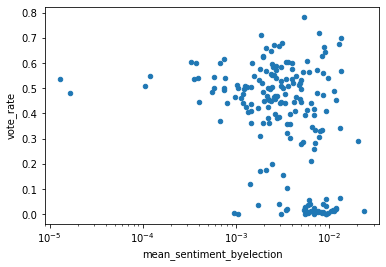

In [83]:
# We add the vote rate and plot the scatter plot of vote rate against total quotes by election
senti_byelection['vote_rate'] = senti_byelection.index.map(candidate_info_byname['vote_rate'])

# linear regression
senti_vote = senti_byelection.plot.scatter(x = 'mean_sentiment_byelection', y = 'vote_rate', logx=True)
(corr1, pvalue) = pearsonr(senti_byelection['mean_sentiment_byelection'], senti_byelection['vote_rate'])
print(f'Pearson coefficient: {corr1}, p value: {pvalue}')

There is no significant (p-value > 0.05) correlation between the sentiment in quotes and final vote rate!

## 3. Features for Prediction Model (This is the OLD CODE)
In the proposal, we decide to build a model predicting election results based on quotation data. Here, we preprocess the quote data and candidate data to generate the features for training our model.

The first feature is the change of quotation number over time. We will also use this for clustering analysis in proposed question 3.

In [ ]:
date_start=pd.to_datetime('2015-01-01', format='%Y-%m-%d') 
all_date = (pd.to_datetime('2020-12-31', format='%Y-%m-%d') - date_start).days # number of days.
candidate_quotes_name = candidate_quotes_byday.index.map(lambda x:x[0]).drop_duplicates()
candidate_quotes_feature = pd.DataFrame(np.zeros([all_date,len(candidate_quotes_name)]), columns=candidate_quotes_name) # initialize frequency vector

for candidate in candidate_quotes_name:
    candidate_mention = candidate_quotes_byday[candidate]
    for date in candidate_mention.index:
        date2days = (pd.to_datetime(date, format='%Y-%m-%d') - date_start).days # convert date to num of days w.r.t. start date
        candidate_quotes_feature[candidate].iloc[date2days] = candidate_mention.loc[date]

In [84]:
candidate_quotes_byday

speaker           date_only 
A. WAYNE JOHNSON  2015-01-06    0.601997
                  2015-02-09    0.602585
                  2015-02-11    1.205169
                  2015-02-20    0.602585
                  2015-03-01    0.535357
                                  ...   
ZAK RINGELSTEIN   2018-10-30    5.125275
                  2018-11-01    2.381878
                  2018-11-05    0.476376
                  2018-11-07    0.476376
                  2019-03-21    0.503878
Name: normalize_quotes, Length: 136070, dtype: float64

We also include the party affiliation of each candidate. Moreover, we also consider the affiliated party's vote rate in the most recent presidential election. Since we are looking at the election from 2016 to 2021, we will use the 2016 presidential election data for the senate election from 2016 to 2019, and use the 2020 presidential election data for the senate election from 2020 to 2021.

The presidential election data also comes from the MIT Election Data and Science Lab[2]. It contains the presidential election voting result by each state.

[2]MIT Election Data and Science Lab, 2017, "U.S. President 1976–2020", https://doi.org/10.7910/DVN/42MVDX, Harvard Dataverse, V6.

In [85]:
# We load 2016 and 2020 result separately
president = pd.read_csv('SenateData/1976-2020-president.csv')
president16 = president[president['year'] == 2016].copy()
president20 = president[president['year'] == 2020].copy()
president16.sample(4) #display format of president election data

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
3432,2016,COLORADO,CO,8,84,62,US PRESIDENT,"TRUMP, DONALD J.",REPUBLICAN,False,1202484,2780220,20210113,NaN,REPUBLICAN
3652,2016,OKLAHOMA,OK,40,73,53,US PRESIDENT,"JOHNSON, GARY",LIBERTARIAN,False,83481,1452992,20210113,NaN,LIBERTARIAN
3636,2016,NORTH CAROLINA,NC,37,56,47,US PRESIDENT,SCATTERING,NaN,True,47386,4741564,20210113,NaN,OTHER
3534,2016,MAINE,ME,23,11,2,US PRESIDENT,NaN,UNENROLLED,False,2243,771892,20210113,NaN,OTHER


In [86]:
# We add vote rate to each candidate in each state
president16['vote_rate'] = president16['candidatevotes']/president16['totalvotes']
president20['vote_rate'] = president20['candidatevotes']/president20['totalvotes']

In [87]:
# We group the data by states and party_simplified (represent small parties, independent, NaN all by 'Others'). 
# We take sum of vote rates of cadidates from the same party_simplified
vote_byparty16 = president16.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty20 = president20.groupby(['state', 'party_simplified'])['vote_rate'].sum()
vote_byparty16

state      party_simplified
ALABAMA    DEMOCRAT            0.343579
           LIBERTARIAN         0.020942
           OTHER               0.014648
           REPUBLICAN          0.620831
ALASKA     DEMOCRAT            0.365509
                                 ...   
WISCONSIN  REPUBLICAN          0.472182
WYOMING    DEMOCRAT            0.216289
           LIBERTARIAN         0.051343
           OTHER               0.058384
           REPUBLICAN          0.673984
Name: vote_rate, Length: 201, dtype: float64

In [88]:
# We create feature dataframe and add in party_simplified, party vote rate in most recent presidential election, and final vote rate
# If the senate candidate's affiliated party does not show up in the most recent president election, party_vote_rate is 0
features = candidate_info_byname[['party_simplified', 'vote_rate']].copy()
for name in features.index:
    state_ = candidate_info_byname.loc[name, 'state']
    party_ = candidate_info_byname.loc[name, 'party_simplified']
    if candidate_info_byname.loc[name, 'year'] < 2020: #for candidate before 2020
        if party_ in vote_byparty16[state_].index:  #check whether the affiliated party is in recent president election
            features.loc[name, 'party_vote_rate'] = vote_byparty16[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0
    else:
        if party_ in vote_byparty20[state_].index: 
            features.loc[name, 'party_vote_rate'] = vote_byparty20[state_][party_]
        else: 
            features.loc[name, 'party_vote_rate'] = 0

# 4. statistics of sentence complexity (ALSO OLD Code)

We also calculated the average length of sentence and word of each quotation. This information may be used in our analysis about speech style (question 6).

In [89]:
# calculate average sentence length (by word number)
import re
candidate_quotes['split_quotation']=candidate_quotes.quotation.map(lambda x:re.split(r'\.|!|\?',x))
candidate_quotes['split_quotation']=candidate_quotes.split_quotation.map(lambda x:list(filter(None, x))) # remove empty string
candidate_quotes['avg_sentence_length'] = candidate_quotes.split_quotation.map(lambda x:np.mean(list(map(lambda s:len(s.split()), x))))
candidate_quotes.head(4)

,index,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,normalize_factor,normalize_quotes,date_only,election_day,views,normalize_views,days_before_election,split_quotation,avg_sentence_length
0,0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",0.473512,0.947023,2015-08-31,2020-11-01,1.350,0.639241,1889,[ a great day for veterans here in Littleton a...,21.500000
1,1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],0.416694,0.416694,2015-10-25,2018-11-01,0.675,0.281269,1103,"[' It is not now, nor has it ever been, the go...",24.333333
2,2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],0.559562,0.559562,2015-11-13,2016-11-01,0.675,0.377704,354,"[[ My dad ] saw what a great opportunity it was,]",11.000000
3,3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],1.007044,1.007044,2015-06-26,2020-11-01,0.675,0.679755,1955,[hurt Michigan workers and cost thousands of A...,10.000000


In [33]:
# calculate average word lenghth for each quotation
candidate_quotes['split_words'] = candidate_quotes.quotation.map(lambda x:x.split())
candidate_quotes['avg_word_length'] = candidate_quotes.split_words.map(lambda x:np.mean(list(map(lambda w:len(w), x))))
candidate_quotes.head(4)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,domains,date_only,election_day,split_quotation,avg_sentence_length,split_words,avg_word_length
0,2015-08-31-000271,... a great day for veterans here in Littleton...,JEANNE SHAHEEN,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E,"[com, com]",2015-08-31,2020-11-01,[ a great day for veterans here in Littleton a...,21.500000,"[..., a, great, day, for, veterans, here, in, ...",4.318182
1,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",BERNIE SANDERS,[Q359442],2015-10-25 14:12:35,1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[com],2015-10-25,2018-11-01,"[' It is not now, nor has it ever been, the go...",24.333333,"[', It, is, not, now,, nor, has, it, ever, bee...",3.931507
2,2015-11-13-000427,"[ My dad ] saw what a great opportunity it was,",PAUL STANTON,"[Q255668, Q27842994]",2015-11-13 08:45:01,1,"[[Paul Stanton, 0.6521], [None, 0.3479]]",[http://thecrimson.com/article/2015/11/13/paul...,E,[com],2015-11-13,2016-11-01,"[[ My dad ] saw what a great opportunity it was,]",11.000000,"[[, My, dad, ], saw, what, a, great, opportuni...",3.363636
3,2015-06-26-015863,hurt Michigan workers and cost thousands of Am...,GARY PETERS,"[Q1230954, Q1494930, Q5525742, Q56560036]",2015-06-26 22:31:05,1,"[[Gary Peters, 0.7907], [None, 0.2093]]",[http://detroitnews.com/story/news/politics/20...,E,[com],2015-06-26,2020-11-01,[hurt Michigan workers and cost thousands of A...,10.000000,"[hurt, Michigan, workers, and, cost, thousands...",6.300000
